# Variational autoencoders

A variational autoencoder (VAE) is a probabilistic model that allows us to encode data to a latent space as well as sampling new data from this latent space.

The main difference between a VAE and a regular autoencoder (AE) is that a AE encodes a single sample as a single point into the latent space, while the VAE assigns a continous probability distribution to that point. While we can interpolate between 2 points in the latent space learned by the AE this interpolation might not necessarly mean anything or give good generated samples. In the VAE this interpolation is more natural because it learned to encode samples as a continous probability distribution which assigns meaning to the full latent space. Additional to this since the VAE assigns a distribution to the latent space we can easily sample new samples from it in a probabilistic way.

In what follows we'll describe the probabilistic nature of the VAE and derive the optimization function. We'll illustrate this in practice on Mnist data.

TODO: Image to show difference

In [1]:
%matplotlib inline

import warnings

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
tf.logging.set_verbosity(tf.logging.WARN)
# Reproducability
SEED = 0
tf.set_random_seed(SEED)
np.random.seed(SEED)

/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# @make_template as a function decorator for tf.make_template
make_template = lambda func: tf.make_template(func.__name__, func)

## Data: MNIST

We'll be training a VAE to encode and decode images of handwritten digits from the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. Each image is a $28 \times 28 $ image which we scale so that each pixel has a value between 0 and 1.

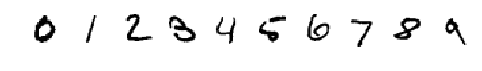

In [3]:
# Load data and plot examples
IMG_SHAPE = (28, 28)  # Shape of Mnist image
BATCH_SIZE = 64

# Load Mnist data
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalise data so each pixel is between 0 and 1
x_train = x_train / 255.
x_test = x_test / 255.

# Tensorflow dataset iterator for training
train_batch = tf.data.Dataset.from_tensor_slices(x_train).shuffle(
    buffer_size=1000, seed=SEED
    ).repeat().batch(BATCH_SIZE).make_one_shot_iterator().get_next()

# Plot examples from test
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))
for i in range(10):
    axs[i].imshow(np.squeeze(x_test[np.argwhere(y_test==i)[0]]), cmap=cm.binary)
    axs[i].set_axis_off()
plt.show()

## VAE: Encoder & Decoder

The VAE consists of two main components:

- **Encoder**: $q_{\theta}(Z \mid x)$ with parameters $\theta$, which given a datapoint $x$ returns a distribution in the latent space $Z$.
- **Decoder**: $p_{\phi}(x \mid z)$ with parameters $\phi$, which reconstructs (decodes) data $x$ from a given latent point $z$.

TODO: illustration of VAE encoder/decoder

Note that we are using lower case $x$ or $z$ do denote specific datapoints $x$ or latent (encoding) points $z$. And upper case $X$ to denote the full space that points $x$ can take and $Z$ to denote the full latent space that points $z$ can take.

Now, how can we actually model this encoder and decoder and train them on our dataset?

## Generative probabilistic model

The VAE is a probabilistic generative model that learns to generate the dataset $x$ from a model with latent variables $z$.

TODO: image z -> x

We can only observe $x$ but we would like to infer the underlying encoding $z$ given a sample $x$. In general we would like to compute $p(Z \mid X)$:

$$
p(Z \mid X) = \frac{p(X, Z)}{p(X)} = \frac{p(X \mid Z) P(Z)}{p(X)}
$$

Unfortunately the marginal density $p(X) = \int P(X \mid Z) p(Z) dZ$ is difficult to compute because $Z$ is an unobserved latent variable that we need to integrate out. To compute $p(Z \mid X)$ we need to look at every possible value that $Z$ can take, which is intractable.

### Approximate inference

We could circumvent the calculation of $p(Z \mid X)$ by approximating it with a parametrized distribution $q_{\theta}(Z \mid X)$ that we know how to do posterior inference for, for example a [Gaussian](https://en.wikipedia.org/wiki/Normal_distribution) distribution. We call this distribution $q_{\theta}(Z \mid X)$ the [variational distribution](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). Note that this correponds to the encoder in the VAE.

We can then optimize the parameters $\theta$ so that the variational distribution $q_{\theta}(Z \mid X)$ is as close to the true distribution $p(Z \mid X)$ as possible. How do we define this "closeness"? Well, it turns out there is a measure of how one probability distribution is different from a second, reference probability distribution, called the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). The KL divergence measures how much information is lost when we approximate $p(Z \mid X)$ by $q_{\theta}(Z \mid X)$ and is defined as:

$$
KL(q_{\theta}(Z \mid X) \,\Vert\, p(Z \mid X)) 
= \int q_{\theta}(Z \mid X) \log \frac{p(Z \mid X)}{q_{\theta}(Z \mid X)} dZ$$

Since we want to minimize the information lost we will try to minimize this KL divergence. We need to know how to compute this KL divergence before we can minimize it, so in what follows we derive the extact formula we're going to minimize in our example. Note that since dataset $x$ is given we will use $q(Z)$ in short for $q_{\theta}(Z \mid X=x)$:

$$
KL(q(Z) \,\Vert\, p(Z \mid X)) 
= \int q(Z) \log \frac{q(Z)}{p(Z \mid X)} dZ
= \int q(Z) \log q(Z) \frac{p(X)}{p(X,Z)} dZ \\
= \int q(Z) \log \frac{q(Z)}{p(X,Z)} dZ + \int q(Z) \log p(X) dZ
= \log p(X) - \int q(Z) \log \frac{p(X,Z)}{q(Z)} dZ
$$

Which we we rewrite as:

$$
\log p(X) = KL(q(Z) \,\Vert\, p(Z \mid X)) + \int q(Z) \log \frac{p(X,Z)}{q(Z)} dZ
$$

Note that $\log p(X)$ is a constant given our data and that we wanted to minimize the KL divergence. This means that instead of minimizing the KL divergence we can maximize the lower bound $\int q(Z) \log \frac{p(X,Z)}{q(Z)} dZ$ and have the same result. This lower bound is also known as ELBO (Evidence Lower BOund). 

TODO: figure of ELBO bounding

We can rewrite this as:

$$
\text{ELBO} 
= \int q(Z) \log \frac{p(X,Z)}{q(Z)} dZ 
= \int q(Z) \log \frac{p(X \mid Z)p(Z)}{q(Z)} dZ \\
= \int q(Z) \log p(X \mid Z) dZ + \int q(Z) \log \frac{p(Z)}{q(Z)} dZ \\
= \int q(Z) \log p(X \mid Z) dZ - KL(q(Z) \,\Vert\, p(Z)) 
$$

Given data $x$ and following the definition of the [expected value](https://en.wikipedia.org/wiki/Expected_value) $\mathbb{E}$ we can write our optimization objective as:

$$
\underset{\theta, \phi}{\text{argmax}}\;\text{ELBO} = \underset{\theta, \phi}{\text{argmax}}\;\left( \mathbb{E}_q[\log(p_{\phi}(x \mid Z)] -  KL(q_{\theta}(Z \mid x) \,\Vert\, p(Z)) \right)
$$

We'll see further how to actually implement this.

## VAE: Implementation

We will implement the VAE using [Tensorflow](https://www.tensorflow.org/) to model the neural network side of things and we will use [Tensorflow Probability](https://www.tensorflow.org/probability/) to model the distributions so that we can easily sample from them later or use readily implemented methods like the KL divergence.

### Encoder

Now that we understand the formulation of our encoder $q_{\theta}(Z \mid x)$ we can model this as a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) where we regress the parameters $\mu$ (the mean) and $\text{diag}(\sigma)$ (diagonal of the covariance matrix) with a neural network parametrized by $\theta$:

$$
q_{\theta}(Z \mid x) = \mathcal{N}(\mu_{\theta}, \text{diag}(\sigma)_{\theta})
$$

Note that we ensure that $\text{diag}(\sigma)_{\theta}$ is strictly positive by passing it through a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus) function. We choose to model the multivariate normal with 2 dimensions for easy visualisation later on.

In [4]:
EMBEDDING_DIMS = 2  # Number of dimensions in latent embedding


@make_template
def encoder(x):
    """Variational distribution q(Z|X)"""
    net = tf.layers.flatten(x)
    net = tf.layers.dense(net, 256, tf.nn.relu)
    net = tf.layers.dense(net, 64, tf.nn.relu)
    loc = tf.layers.dense(net, EMBEDDING_DIMS)
    scale = tf.layers.dense(net, EMBEDDING_DIMS, activation=tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)

### Prior

The prior distribution $p(Z)$ over $Z$ will be modelled by a simple multivariate normal distribution with independent components:

$$
p(Z) = \mathcal{N}(0, I_2)
$$

The encoder distribution $q_{\theta}(Z \mid x)$ will be optimized to be close to $p(Z)$.

In [5]:
# Prior p(Z)
z_prior = tfd.MultivariateNormalDiag(
    tf.zeros(EMBEDDING_DIMS), 
    tf.ones(EMBEDDING_DIMS))

### Decoder

The decoder $p_{\phi}(x \mid z)$ will take a sample $z$ from the latent distribution $p(Z)$ and reconstruct and image $x$. The "reconstructing" process in the decoder returns an $28 \times 28$ image $x$ of which each pixel $x_{ij}$ will have a value between 0 and 1. We can model this by assigning a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) to each pixel independently. The neural network regresses the [logits](https://en.wikipedia.org/wiki/Logit) for this Bernoulli distribution, which are the log-odds of outputting 1 vs 0. 

In [6]:
@make_template
def decoder(z):
    """p(X|z)"""
    net = tf.layers.dense(z, 64, tf.nn.relu)
    net = tf.layers.dense(net, 256, tf.nn.relu)
    logit = tf.layers.dense(net, np.prod(IMG_SHAPE))
    logit = tf.reshape(logit, [-1, *IMG_SHAPE])
    return tfd.Independent(
        tfd.Bernoulli(logit), reinterpreted_batch_ndims=2)

### VAE model

We will be building a couple of different input-output flows for our tensorflow model:
- `x_z_x` which outputs a reconstruction of $x$ given in input `x`. This will be used for training.
- `x_samples` which returns `nb_samples` samples from $p(X,Z)$.
- `x_z` which returns reconstructed $x$ given a latent points $z$ in `z`.

In [7]:
# Model for training
# Input mnist images placeholder
x = tf.placeholder(tf.float32, shape=[None, *IMG_SHAPE])
variational_posterior = encoder(x)  # q(Z|X)
z_x = variational_posterior.sample()  # samples z ~ q(Z|X)
x_z_x = decoder(z_x)  # Reconstructed x given z ~ q(Z|X)
# For testing
# Decoded samples from prior (reconstruction without input data)
nb_samples = tf.placeholder(tf.int32, shape=())
x_samples = decoder(z_prior.sample(nb_samples)).mean()
# Decoded from given prior samples
z = tf.placeholder(tf.float32, shape=[None, 2])
x_z = decoder(z).mean()

### Optimization

We deduced above that we wanted to maximize the ELBO with respect to parameters $\theta$ and $\phi$:

$$
\underset{\theta, \phi}{\text{argmax}}\;\text{ELBO} = \underset{\theta, \phi}{\text{argmax}}\;\left( \mathbb{E}_q[\log(p_{\phi}(x \mid Z)] -  KL(q_{\theta}(Z \mid x) \,\Vert\, p(Z)) \right)
$$

Where $\mathbb{E}_q[\log(p_{\phi}(x \mid Z)]$ is the [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function) of the [Bernoulli variables](https://en.wikipedia.org/wiki/Bernoulli_distribution) $x$, which is the negative of the [cross entropy of the logistic function](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo01/) between the reconstructed image $x'$ and the original image $x$.

$$
\mathbb{E}_q[\log(p_{\phi}(x \mid Z)] = - \sum_{i=1, j=1}^{28,28} x_{ij} \log(x'_{ij}) + (1-x_{ij}) \log(1-x'_{ij})
$$


$KL(q_{\theta}(Z \mid x) \,\Vert\, p(Z))$ is the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between $q_{\theta}(Z \mid x) = \mathcal{N}(\mu, \text{diag}(\sigma))$ and $p(Z) = \mathcal{N}(0, I)$ which are both multivariate normal distributions. Given the parameters of these distributions and the KL-divergence between the diagonal multivariate normal $q_{\theta}(Z \mid x)$, and a standard normal distribution $p(Z)$ has a closed form definition:

$$
KL \left( \mathcal{N}(\mu, \text{diag}(\sigma)) \,\Vert\, \mathcal{N}(0, I) \right)
= \frac{1}{2} \sum^{k}_{i=1} (\sigma_i + \mu_i^2 - log(\sigma_i) - 1)
$$

With $k=2$ the dimensionality of our multivariate normal distributions.

We don't have to implement these functions ourselves and can write this out easily by leveraging Tensorflow Probability. Note that because Tensorflow is made to minimize we can reformulate our optimization problem as:

$$
\underset{\theta, \phi}{\text{argmax}}\;\text{ELBO} = \underset{\theta, \phi}{\text{minimize}}\;-\text{ELBO}
$$

In [8]:
# Optimization
likelihood = x_z_x.log_prob(x)  # Likelihood of reconstruction
kl = tfd.kl_divergence(variational_posterior, z_prior)
neg_elbo = -tf.reduce_mean(likelihood - kl)
optimize = tf.train.AdamOptimizer(0.003).minimize(neg_elbo)

### Training the model

Now that we've fully defined the model and how to optimize it we can start training. We will keep track of our optimization metrics during training for later plotting.

Note that the KL-divergence (right y-axis of plot) stays quite low compared to the ELBO and decoding log-likelihood (left y-axis of plot) and only makes a jump in the beginning of training. We can also see this in the sample plots which have the center of the embedding distributions plotted on the left. These embeddings deviate from the normal distribution in the beginning of training but center again quite soon.

In [9]:
# Dictionary to store model results during training
test_iterations = dict.fromkeys(
    [0, 5, 10, 25, 100, 500, 1000, 10000, 25000, 50000])
# List to store training metrics for plotting
train_iterations = []
sess = tf.Session()
with sess.as_default():
    sess.run(tf.global_variables_initializer())
    for i in range(max(test_iterations.keys())+1):
        # Get evaluations from test set
        if i in test_iterations:
            neg_elbo_test, z_test = sess.run(
                [neg_elbo, z_x], 
                feed_dict={x: x_test.reshape([-1, *IMG_SHAPE])})
            x_samples_test = sess.run(
                x_samples,
                feed_dict={nb_samples: 5})
            test_iterations[i] = neg_elbo_test, z_test, x_samples_test
            print(f'Iteration {i: <5} -ELBO: {neg_elbo_test:.2f}')
        # Run optimization while getting training metrics
        (likelihood_eval, kl_eval, neg_elbo_eval, 
         _) = sess.run([likelihood, kl, neg_elbo, optimize], 
                        feed_dict={x: train_batch.eval(session=sess)})
        # Save training metrics for plotting
        train_iterations.append((
            np.mean(likelihood_eval), np.mean(kl_eval), neg_elbo_eval))

Iteration 0     -ELBO: 543.81
Iteration 5     -ELBO: 366.91
Iteration 10    -ELBO: 261.06
Iteration 25    -ELBO: 210.03
Iteration 100   -ELBO: 186.56
Iteration 500   -ELBO: 168.97
Iteration 1000  -ELBO: 161.84
Iteration 10000 -ELBO: 145.95
Iteration 25000 -ELBO: 142.64
Iteration 50000 -ELBO: 143.11


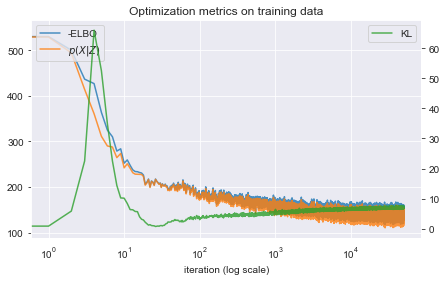

In [10]:
# Plot training graphs
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
likelihoods, kls, neg_elbos = zip(*train_iterations)
likelihoods = [-l for l in likelihoods]
ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel('iteration (log scale)')
ax1.set_title('Optimization metrics on training data')
ax1.plot(neg_elbos, label='-ELBO', color=cm.tab10(0), alpha=0.8)
ax1.plot(likelihoods, label='$p(X|Z)$', color=cm.tab10(1), alpha=0.8)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot( kls, label='KL', color=cm.tab10(2), alpha=0.8)
ax2.grid(False)
ax2.legend(loc='upper right')
plt.show()

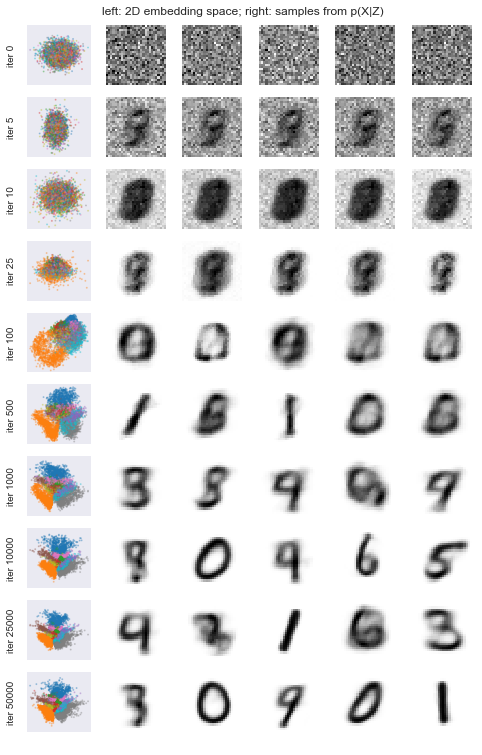

In [11]:
# Plot test embedding and decoded samples from prior
def plot_embeddings(ax, embeddings, labels):
    """Plot embedding points and color according to label."""
    with sns.axes_style('white'):
        ax.scatter(
            embeddings[:, 0], embeddings[:, 1], 
            s=1, c=labels, alpha=0.3, cmap=cm.tab10)
    ax.set_aspect('equal', 'datalim')
    sns.despine(ax=ax,top=True, right=True, left=True, bottom=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)

def plot_decoded_samples(ax, samples):
    """Show decoded image sample"""
    for idx, sample in enumerate(samples):
        ax[idx].imshow(sample, cmap=cm.binary)
        ax[idx].set_axis_off()

# Plot test embeddings and decode samples
fig, ax = plt.subplots(
    nrows=len(test_iterations), ncols=6, figsize=(8, 13))
fig.suptitle('left: 2D embedding space; right: samples from p(X|Z)', y=0.9)
for plot_idx, (i, val) in enumerate(test_iterations.items()):
    neg_elbo_test, z_test, x_samples_test = val
    plot_embeddings(ax[plot_idx, 0], z_test, y_test)
    plot_decoded_samples(ax[plot_idx, 1:], x_samples_test)
    ax[plot_idx, 0].set_ylabel(f'iter {i}')
plt.show()

### Visualising the embedding space

The next figure is a visualisation of the trained embedding space at the last iteration of training. The full dataset is projected to points in the latent embedding space $Z$ and shown as colorred points with the color corresponding to the digit in the image. On top of the embedding space we took $z$ coordinates over a grid and visualised the reconstructed images $p(x \mid z)$ on top of the embedding space.

Note that the embedding space picks up things like different rotations of number $1$ and morphing between numbers such as $9$ to $7$.

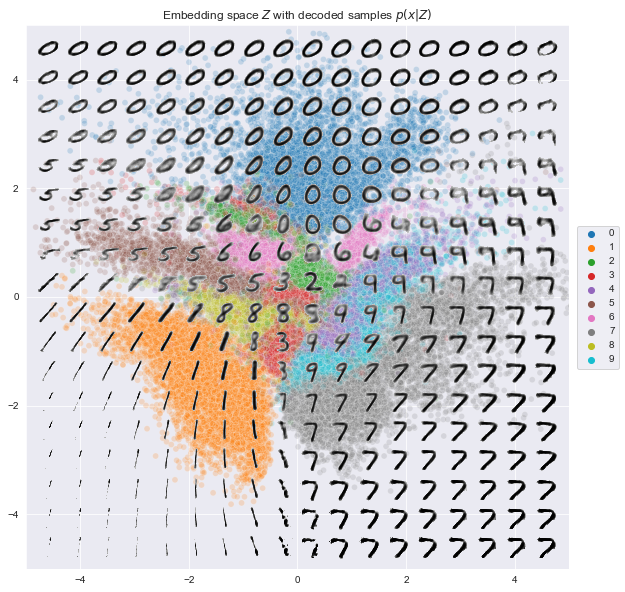

In [14]:
# Plot decoded samples from latent space on top of the latent space
# Combine training and testing data
x_all = np.vstack((x_train, x_test))
y_all = np.hstack((y_train, y_test))

# Plot limits
limits = (-5, 5)

# Get embedding points of all samples and get decodings along grid
with sess.as_default():
    # Embeddings of (x_train, x_test)
    embeddings = sess.run(
        z_x, feed_dict={x: x_all.reshape([-1, *IMG_SHAPE])})
    # Embedding coordinates in grid
    z_grid_coords = np.asarray([
        (x, y) for x in np.linspace(limits[0]+0.5, limits[1]-0.5, num=18)
        for y in np.linspace(limits[0]+0.5, limits[1]-0.5, num=18)
    ])
    # Samples from encoder along `z_grid_coords`
    z_grid_samples = sess.run(x_z, feed_dict={z: z_grid_coords})

    
# Plot all embeddings with encoded samples on top
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sc = sns.scatterplot(
    x=embeddings[:, 0], y=embeddings[:, 1], hue=y_all,
    legend='full', palette=cm.tab10, alpha=0.2, ax=ax)
sc.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)
ax.set_aspect('equal', 'box')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_title('Embedding space $Z$ with decoded samples $p(x|Z)$')

# Plot all encoded samples on top of the embedding space
#  (samples are plotted on their respective z-coordinates)
for i in range(z_grid_coords.shape[0]):
    # Create image with alpha channel
    img = Image.fromarray(np.uint8((1-z_grid_samples[i])*255))
    img = img.convert('RGB')
    img.putalpha(Image.fromarray(np.uint8((z_grid_samples[i]>0.2)*255)))
    # Show image on plot
    img_plot = OffsetImage(img, cmap=cm.binary, zoom=1.0)
    img_plot.image.axes = ax
    ab = AnnotationBbox(
        img_plot, xy=(z_grid_coords[i,0], z_grid_coords[i,1]),
        xycoords='data',
        boxcoords='offset points',
        frameon=False)                                  
    ax.add_artist(ab)

plt.show()